In [1]:
import cfe

cfe.logger.setLevel("DEBUG")
cfe.settings.backend = "python_function"

[2025年01月14日 20时41分52秒] INFO                                                                                 
                                          _____     _ _ ______    _       ______            _                      
                                         / ____|   | | |  ____|  | |     |  ____|          | |                     
                                        | |     ___| | | |__ __ _| |_ ___| |__  __  ___ __ | | ___  _ __ ___ _ __  
                                        | |    / _ \ | |  __/ _` | __/ _ \  __| \ \/ / '_ \| |/ _ \| '__/ _ \ '__| 
                                        | |___|  __/ | | | | (_| | ||  __/ |____ >  <| |_) | | (_) | | |  __/ |    
                                         \_____\___|_|_|_|  \__,_|\__\___|______/_/\_\ .__/|_|\___/|_|  \___|_|    
                                                                                     | |                           
                                                                              

Data

In [2]:
import pandas as pd
import scanpy as sc

# creating from Anndata
adata = sc.read_h5ad(f"../tests/data/bifurcating.h5ad")
fadata = cfe.data.FateAnnData.from_anndata(adata)
fadata.layers["counts"] = fadata.X.copy()
fadata.layers["expression"] = fadata.X.copy()

cluster_key = "lineage"
fadata.obs.index = fadata.obs["cell_id"].tolist()

fadata

                        DEBUG    Create a FateAnnData object from an existing AnnData object.                      


AnnData object with n_obs × n_vars = 1000 × 250
    obs: 'cell_id', 'from', 'to', 'time', 'lineage', 'global_time', 'lin_time_sC -> sEndC', 'lin_time_sA -> sB', 'lin_time_sB -> sBmid', 'lin_time_sBmid -> sC', 'lin_time_sD -> sEndD', 'lin_time_sBmid -> sD'
    uns: 'endpoints', 'gt_velocities', 'lineage_colors', 'startpoints', 'cfe'
    obsm: 'X_emb', 'X_umap'
    layers: 'spliced', 'unspliced', 'counts', 'expression'

Method

In [3]:
method = cfe.method.FateMethod(method_name="paga")

                        DEBUG    FunctionBackend __init__                                                          
                        INFO     Loaded function: <function cf_paga at 0x7b59fabbe200> from                        
                                 /home/huang/PyCode/scRNA/CellFateExplorer/CellFateExplorer/cfe/method/function/cf_
                                 paga.py                                                                           
                        INFO     method_backend: <cfe.method.fate_function_backend.FunctionBackend object at       
                                 0x7b59fa366f20>                                                                   


In [4]:
# PAGA need more prior information and parameters
prior_information = {
    "start_id": "cell1",
    "groups_id": fadata.obs[cluster_key].tolist()
}
parameters = {"filter_features": False, "connectivity_cutoff": 0.5}
fadata.add_prior_information(**prior_information)  # add prior information to fadata
method.infer_trajectory(fadata, parameters=parameters)  # add parameters when inferring trajectory

Normalized count data: X, spliced, unspliced.
Logarithmized X.


/home/huang/.conda/envs/cfe/lib/python3.10/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


[2025年01月14日 20时41分56秒] DEBUG    FateAnnData add_trajectory_branch                                           
                        DEBUG    FateAnnData add_trajectory                                                        


/home/huang/PyCode/scRNA/CellFateExplorer/CellFateExplorer/cfe/method/function/cf_paga.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  branches["length"] = adata.obs[[cluster_key, "dpt_pseudotime"]].groupby(cluster_key).apply(lambda x: x["dpt_pseudotime"].max() - x["dpt_pseudotime"].min() + epsilon).reset_index()[0]


Plot

                        DEBUG    plot_trajectory                                                                   
                        DEBUG    add waypoints                                                                     
                        DEBUG    FateAnnData add_waypoints                                                         


/home/huang/PyCode/scRNA/CellFateExplorer/CellFateExplorer/cfe/plot/add_color.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cell_color_df = milestone_percentages.groupby("cell_id").apply(lambda mpg: mix_color(mpg))


[2025年01月14日 20时41分57秒] DEBUG    add waypoints shape is (208, 1000), finished!                               


/home/huang/PyCode/scRNA/CellFateExplorer/CellFateExplorer/cfe/data/fate_waypoint_wrapper.py:239: DeprecationWarning: Graph.shortest_paths() is deprecated; use Graph.distances() instead
  shortest_paths = gr.shortest_paths(source=waypoint_id_list, target=cell_id_list, weights="length", mode=mode)
/home/huang/PyCode/scRNA/CellFateExplorer/CellFateExplorer/cfe/data/fate_waypoint_wrapper.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.assign(
/home/huang/PyCode/scRNA/CellFateExplorer/CellFateExplorer/cfe/plot/plot_trajectory.py:149: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pand

<Axes: title={'center': 'milestone'}, xlabel='UMAP1', ylabel='UMAP2'>

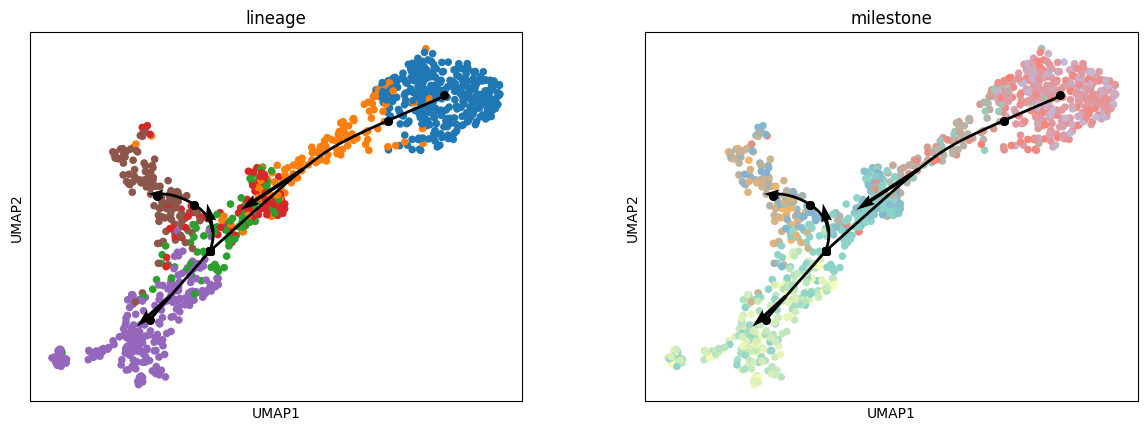

In [6]:
cfe.plot.plot_trajectory(fadata, basis="umap", color=["lineage", "milestone"])

Save

In [7]:
fadata.write_h5ad("output.h5ad")